# Dog Skin Diseases Classification

The notebook incorporates the model utilized for classifying skin diseases of dogs (3 diseases and 1 healthy class). A customley made datasetspecially for Sri Lanka is used for training, validating and testing the model. The development of the classification model followed a transfer learning approach  with a customised CNN layer to extract features together using ResNet50 Keras application. To assess the performance of the model, several evaluation metrics were employed, including accuracy, F1-score, precision, recall, and evaluation matrix. The output from each metric indicates that the model achieved a high level of accuracy in classifying the eye images.


### Importing required libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [2]:
# Set dataset path
TRAIN_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\train'
VAL_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\val'
TEST_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\test'

### Initializing train, validation & test data

In [3]:
# Load the datasets from directories
train_gen = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

val_gen = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

test_gen = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

Found 8795 files belonging to 4 classes.
Found 2513 files belonging to 4 classes.
Found 1257 files belonging to 4 classes.


### Plot Images with labels

In [4]:
# Get class labels
class_labels = train_gen.class_names
print("Class Labels:", class_labels)

Class Labels: ['canine_scabies', 'fungal_infection', 'healthy', 'hypersensitivity_allergies']


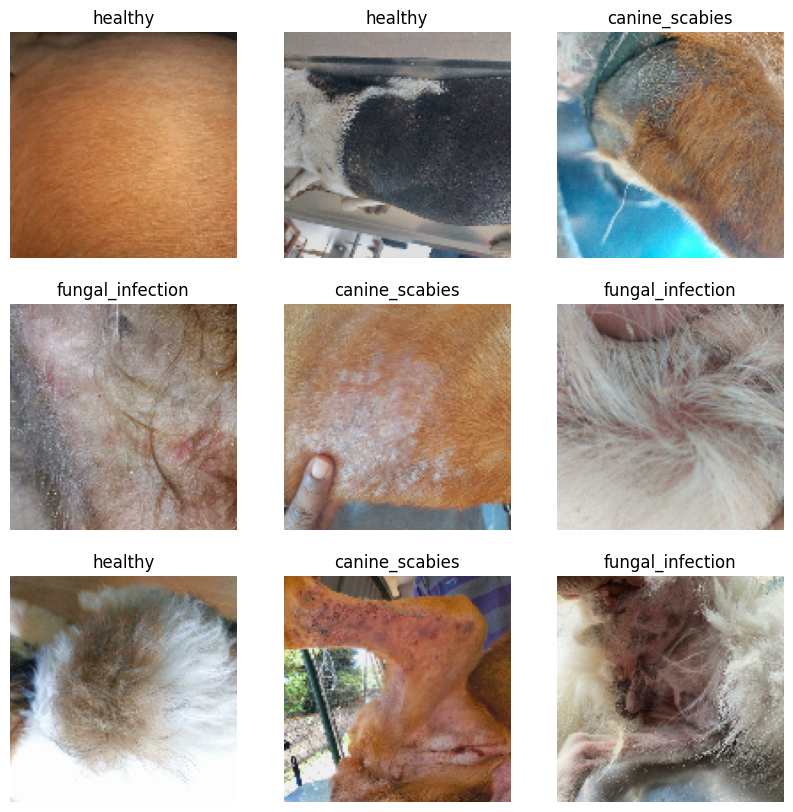

In [5]:

# Function to visualize some images from the dataset
def visualize_images(dataset, class_labels):
    plt.figure(figsize=(10, 10))
    
    for images, labels in dataset.take(1):  # Take one batch from dataset
        images = images.numpy().astype("uint8")  # Convert to NumPy array
        labels = labels.numpy()  # Convert labels to NumPy array
        
        for i in range(9):  # Display 9 images
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i])
            plt.title(class_labels[np.argmax(labels[i])])  # Get class label
            plt.axis("off")
    
    plt.show()

# Call the function
visualize_images(train_gen, train_gen.class_names)

In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

def create_hybrid_cnn_resnet50(input_shape=(128, 128, 3), num_classes=4):
    # CNN part
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)  # Smooth output for merging

    # ResNet152V2 part
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    resnet_base.trainable = False  # Freeze ResNet layers initially
    
    # Unfreeze last 15 layers for fine-tuning
    for layer in resnet_base.layers[-30:]:
        layer.trainable = True

    # Pass original input to ResNet
    resnet_features = resnet_base(inputs)
    resnet_features = layers.GlobalAveragePooling2D()(resnet_features)

    # Combine CNN and ResNet features
    concatenated = layers.Concatenate()([x, resnet_features])

    # Fully connected layers
    x = layers.Flatten()(concatenated)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Build the model
    model = models.Model(inputs, outputs)
    return model

# Create and summarize the hybrid model
hybrid_model = create_hybrid_cnn_resnet50()
hybrid_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 128, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 64, 64, 32)  0           ['conv2d_4[0][0]']               
                                                                                            

In [8]:
# Compile Model
hybrid_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('hybrid_resnet50_best_model.h5', monitor='val_accuracy', save_best_only=True)
lrr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.2, 
    min_lr=0.0001
)


In [10]:
# Training
history = hybrid_model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop, checkpoint, lrr]
)


Epoch 1/30
275/275 [==============================] - ETA: 0s - loss: 1.0244 - accuracy: 0.6106 - precision: 0.6876 - recall: 0.4898

c:\anaconda\envs\gpu_py\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


275/275 [==============================] - 240s 841ms/step - loss: 1.0244 - accuracy: 0.6106 - precision: 0.6876 - recall: 0.4898 - val_loss: 0.6079 - val_accuracy: 0.7648 - val_precision: 0.8179 - val_recall: 0.7008 - lr: 0.0010
Epoch 2/30
275/275 [==============================] - 269s 957ms/step - loss: 0.5784 - accuracy: 0.7743 - precision: 0.8215 - recall: 0.7213 - val_loss: 0.4141 - val_accuracy: 0.8349 - val_precision: 0.8643 - val_recall: 0.8010 - lr: 0.0010
Epoch 3/30
275/275 [==============================] - 262s 926ms/step - loss: 0.4008 - accuracy: 0.8474 - precision: 0.8742 - recall: 0.8175 - val_loss: 0.3244 - val_accuracy: 0.8838 - val_precision: 0.8969 - val_recall: 0.8687 - lr: 0.0010
Epoch 4/30
275/275 [==============================] - 260s 922ms/step - loss: 0.3067 - accuracy: 0.8881 - precision: 0.9013 - recall: 0.8684 - val_loss: 0.2898 - val_accuracy: 0.8949 - val_precision: 0.9044 - val_recall: 0.8842 - lr: 0.0010
Epoch 5/30
275/275 [===========================

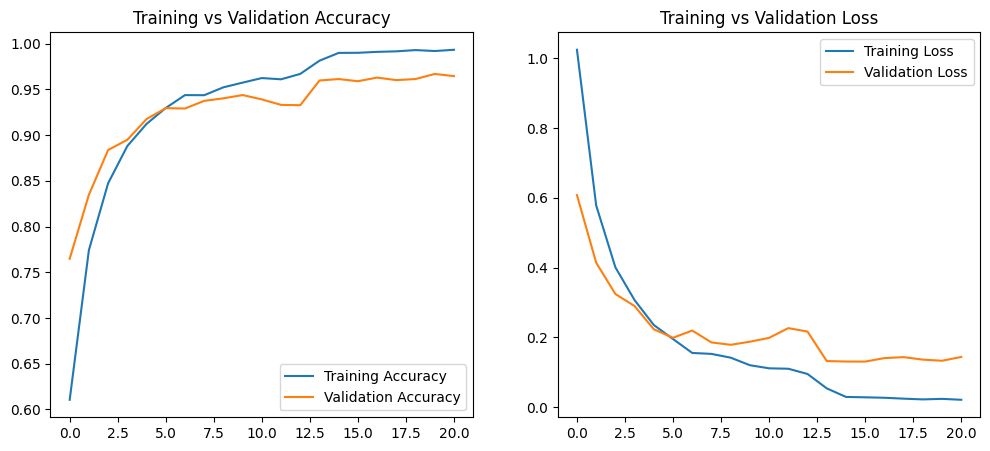

In [11]:
# Evaluation
# Plot Training vs Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] , label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model

# Load the saved model
saved_model = load_model('hybrid_resnet50_best_model.h5')

# Evaluate on training data
train_results = saved_model.evaluate(train_gen, verbose=0)
print(f"Training - Loss: {train_results[0]:.4f}, Accuracy: {train_results[1]*100:.2f}%, Precision: {train_results[2]*100:.2f}%, Recall: {train_results[3]*100:.2f}%")

# Evaluate on validation data
val_results = saved_model.evaluate(val_gen, verbose=0)
print(f"Validation - Loss: {val_results[0]:.4f}, Accuracy: {val_results[1]*100:.2f}%, Precision: {val_results[2]*100:.2f}%, Recall: {val_results[3]*100:.2f}%")

# Evaluate on test data
test_results = saved_model.evaluate(test_gen, verbose=0)
print(f"Test - Loss: {test_results[0]:.4f}, Accuracy: {test_results[1]*100:.2f}%, Precision: {test_results[2]*100:.2f}%, Recall: {test_results[3]*100:.2f}%")


Training - Loss: 0.0007, Accuracy: 99.99%, Precision: 99.99%, Recall: 99.99%
Validation - Loss: 0.1331, Accuracy: 96.70%, Precision: 96.89%, Recall: 96.58%
Test - Loss: 0.1419, Accuracy: 96.58%, Precision: 96.73%, Recall: 96.50%


In [27]:
prediction_effnet = saved_model.predict(test_gen) 
prediction_effnet=np.argmax(prediction_effnet,axis=1)

Classification Report:
                            precision    recall  f1-score   support

            canine_scabies       0.97      0.96      0.97       333
          fungal_infection       0.97      0.97      0.97       344
                   healthy       0.96      0.98      0.97       333
hypersensitivity_allergies       0.97      0.94      0.96       247

                  accuracy                           0.97      1257
                 macro avg       0.97      0.96      0.97      1257
              weighted avg       0.97      0.97      0.97      1257



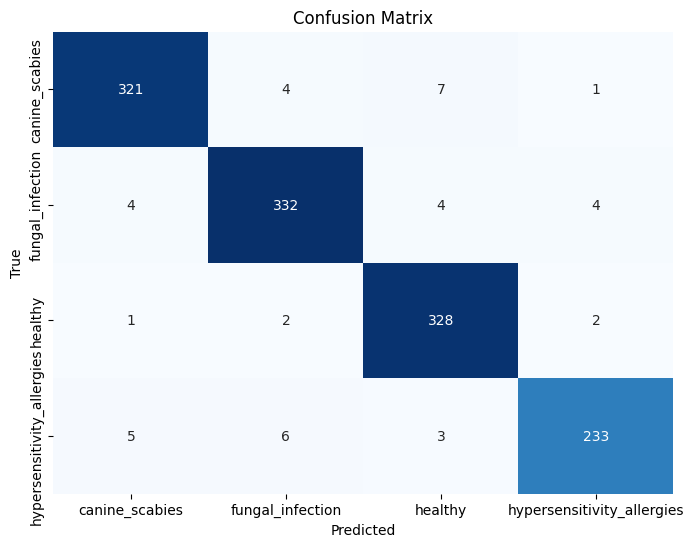

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# List of class names (replace with your actual class names)
class_names = ['canine_scabies', 'fungal_infection', 'healthy', 'hypersensitivity_allergies']  # Modify with your actual class names

# Initialize empty lists to hold true labels and predictions
true_labels = []
predictions = []

# Loop through the test dataset to extract true labels and predictions
for images, labels in test_gen:
    # Convert one-hot encoded labels to class indices (if necessary)
    true_labels.append(np.argmax(labels, axis=1))  # Get class indices from one-hot labels
    preds = saved_model.predict(images)  # Get predictions for the batch
    predictions.append(np.argmax(preds, axis=1))  # Get predicted class labels

# Convert lists to numpy arrays
true_labels = np.concatenate(true_labels)
predictions = np.concatenate(predictions)

# Compute classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Using the model for classification

In [36]:
from keras.models import load_model

load_imagePath = r'E:\Year04\IRP\dataset\dogs\healthy\20240906_104434.jpg'
saved_model = load_model(r'hybrid_resnet50_best_model.h5')

In [37]:
image_size = (128 ,128)

<class 'numpy.ndarray'>
[[1.7474185e-06 1.5137661e-07 9.9999809e-01 3.5094841e-10]]
Classification:  healthy
Value 0.9999981


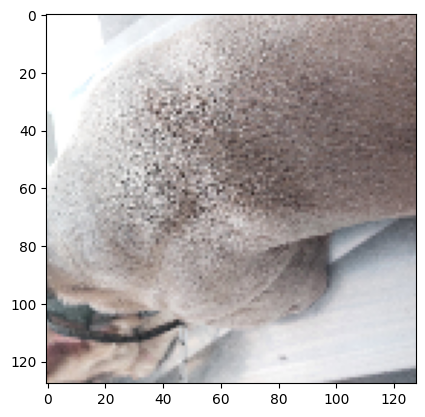

In [38]:
from keras.preprocessing import image

test_img = image.load_img(load_imagePath, target_size = image_size) 
test_image = image.img_to_array(test_img)
test_image = np.expand_dims(test_image, axis = 0)
print(type(test_image))    
result = saved_model.predict(test_image)
print(result)
plt.imshow(test_img) 
print("Classification: ",class_names[int(np.argmax(result,axis=1))])
print("Value", np.amax(result))